In [1]:
import pandas as pd
import numpy as np

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv('telecom_churn.csv')

In [3]:
df.head(10)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,Yes,No,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,121,510,No,Yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,147,415,Yes,No,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,WV,141,415,Yes,Yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


Число строк (клиентов) и столбцов (признаков):

In [4]:
df.shape

(3333, 20)

Посмотрим на признаки и убедимся, что пропусков ни в одном из них нет – везде по 3333 записи:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null object
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null object
Voice mail plan           3333 non-null object
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64


Посмотрим на распределение целевого класса – оттока клиентов:

In [6]:
df['Churn'].value_counts()

False    2850
True      483
Name: Churn, dtype: int64

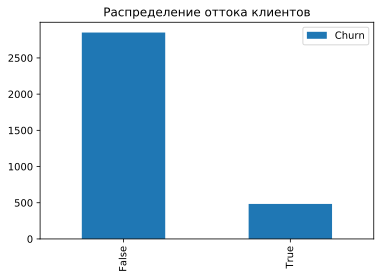

In [7]:
df['Churn'].value_counts().plot(kind='bar', label='Churn')
plt.legend()
plt.title('Распределение оттока клиентов');

Посмотрим на корреляции количественных признаков. По раскрашенной матрице корреляций видно, <br>что такие признаки как Total day charge считаются по проговоренным минутам (Total day minutes). <br>То есть 4 признака можно выкинуть, они не несут полезной информации.

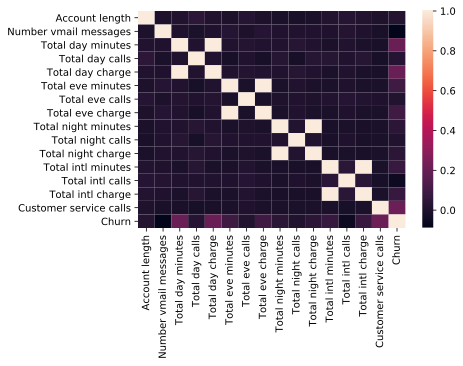

In [8]:
corr_matrix = df.drop(['State', 'International plan', 'Voice mail plan',
                      'Area code'], axis=1).corr()

sns.heatmap(corr_matrix);

Посмотрим на распределения всех интересующих нас количественных признаков:

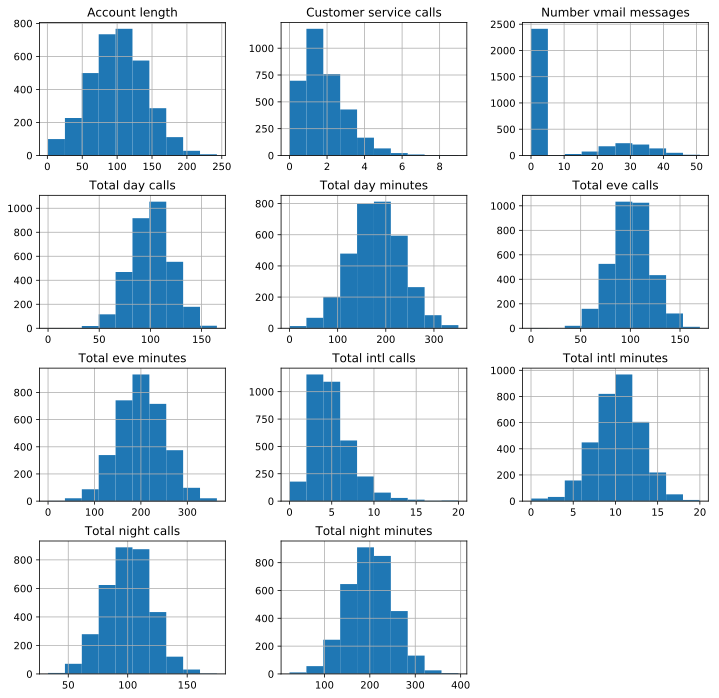

In [9]:
features = list(set(df.columns) - set(['State', 'International plan', 'Voice mail plan',  'Area code',
                                      'Total day charge',   'Total eve charge',   'Total night charge',
                                        'Total intl charge', 'Churn']))

df[features].hist(figsize=(12,12));

Полезно строить картинки, где на главной диагонали рисуются распределения признаков, а вне главной диагонали – <br>диаграммы рассеяния для пар признаков. Бывает, что это приводит к каким-то выводам, <но в данном случае все без сюрпризов.

In [10]:
#sns_plot = sns.pairplot(df[features + ['Churn']], hue='Churn', height = 1);
#sns_plot.savefig('pairplotAgain.png')

<img src="pairplotAgain.png">

----------
--------
--------

Посмотрим, как признаки связаны с целевым – с оттоком.

Построим boxplot-ы, описывающее статистики распределения количественных признаков в двух группах: <br>среди лояльных и ушедших клиентов:

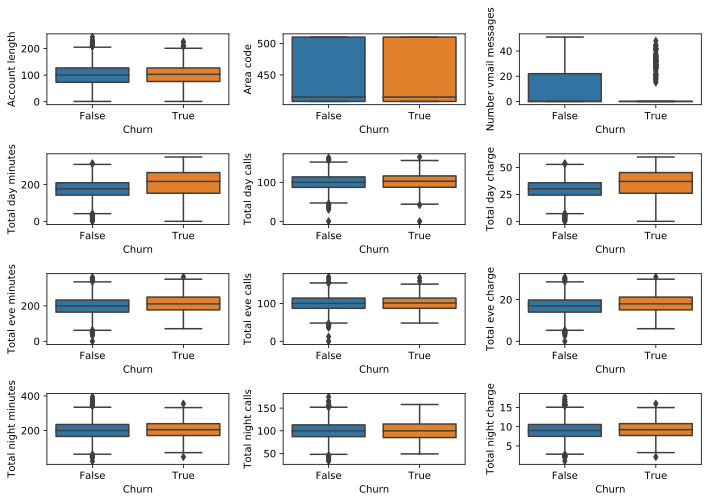

In [11]:
features = df.columns[df.dtypes != object][:12]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 7))
axes = axes.flatten()
for idx, feat in  enumerate(features):
    sns.boxplot(x='Churn', y=feat, data=df, ax=axes[idx])
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(feat)
fig.tight_layout()

Посмотрим на связь бинарных признаков International plan и Voice mail plan с оттоком. 

Наблюдение: когда роуминг подключен, доля оттока намного выше, т.е. наличие международного роуминга – <br>важный признак. Про голосовую почту такого нельзя сказать:

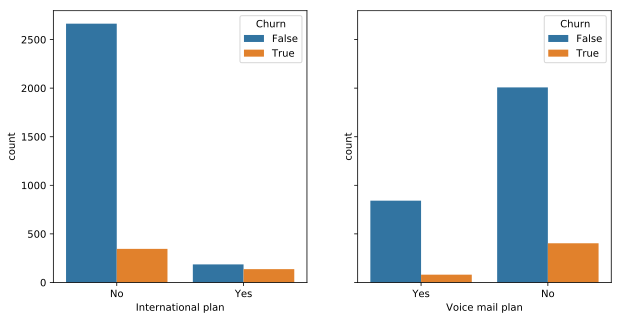

In [12]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))

sns.countplot(x='International plan', hue='Churn', data=df, ax=axes[0]);
sns.countplot(x='Voice mail plan', hue='Churn', data=df, ax=axes[1]);

Доли оттока для каждого штата:

In [13]:
df.groupby(['State'])['Churn'].agg([np.mean]).sort_values(by='mean', ascending=False).T

State,NJ,CA,TX,MD,SC,MI,MS,NV,WA,ME,...,RI,WI,IL,NE,LA,IA,VA,AZ,AK,HI
mean,0.264706,0.264706,0.25,0.242857,0.233333,0.219178,0.215385,0.212121,0.212121,0.209677,...,0.092308,0.089744,0.086207,0.081967,0.078431,0.068182,0.064935,0.0625,0.057692,0.056604
